In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
data = pd.read_csv("r_depression_sample.csv")

<div style="background-color:lightgray; color:#333; padding:15px; border-radius:10px;">
    <center><b><h1>Info about the data</h1></b></center>
    </div>

In [3]:
def df_info(df):
    """Display the basic info about the dataset"""
    
    pd.set_option('display.max_columns', None) # Display all the columns of the dataset
    
    print(f"\033[1m5 head rows of the data:\n\033[0m")
    display(df.head(5))
    
    print(f"\033[1mInfo about the data:\n\033[0m")
    display(df.info())
    
    print(f"\033[1mDescription of the data:\n\033[0m")
    display(df.describe().T)

def df_dupl_null(df, drop=True):
    """
    Handling the duplicates and print info about them and null values 
    """

    # Checking out duplicates
    duplicates = df[df.duplicated()].shape[0]
    if duplicates==0:
        print(f"\033[1mThere are no duplicates in the DataFrame.\033[0m")
    else:
        print(f"\033[1mThere are {duplicates} duplicates in the DataFrame.\033[0m")
        if drop==True:
            df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
            print("Duplicates dropped!")
        else:
            print('Duplicates kept.')
    
    # Checking null values for each column
    pd.set_option('display.max_rows', None)
    rows = df.shape[0]
    print(f"\033[1m \nList of null values for each column in percents:\033[0m \n")
    display((df.isnull().sum()/rows)*100)

def df_outliers(df):
    """
    Finding information about outliers in the df
    and returning it as a DataFrame
    """
    print(f"\033[1m Outliers detection: \033[0m ")
    
    # Get numeric columns excluding any columns with 'id' in their name
    numeric_cols = [col for col in df.select_dtypes(include='number').columns 
                if 'id' not in col.lower()]
    
    outliers_list = []
    # Outlier check for numeric columns
    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_list.append(len(outliers))
        
    rows = df.shape[0]
    # DataFrame for outliers
    outliers_df = pd.DataFrame(
        [[col, len_out, round(len_out/rows, 3)*100] for col, len_out in zip(numeric_cols, outliers_list)],
        columns=['column_name', 'num_of_outliers', 'pctg_of_outliers']
    )

    display(outliers_df)

def df_summary(df):
    """
    Print a summary of the cleaned dataset
    """
    print(f"\033[1mCleaning of the DataFrame completed!\033[0m")
    print(f"{df.shape[0]} rows and {df.shape[1]} columns remaining.")
    for column in df.columns:
        if df[column].nunique()==1:
            df.drop([column], inplace=True, axis=1)
        else:
            print(f"\033[1m- {column}:\033[0m {df[column].nunique()} unique values")

In [4]:
df_info(data)

5 head rows of the data:



,id,author,created_utc,title,selftext,score,num_comments,permalink
0,1m73g2h,Rndom_feels,2025-07-23 08:07:50,When will this end?,I've been dealing with the process of trying t...,1,0,/r/depression/comments/1m73g2h/when_will_this_...
1,1m73fkj,Relative-Cellist-666,2025-07-23 08:06:55,My boyfriend is leaving me and I want to kill ...,I (18f) have been with my boyfriend (18m) for ...,0,0,/r/depression/comments/1m73fkj/my_boyfriend_is...
2,1m7394c,Ib-academic_victim,2025-07-23 07:55:30,I’m gonna kill myself in a few days,I’m happy honestly. I can experience life for ...,1,1,/r/depression/comments/1m7394c/im_gonna_kill_m...
3,1m733zh,ProjectOk3907,2025-07-23 07:45:52,I”ve made wrong decisions,I think I’ve chosen the wrong path. I don’t wa...,1,1,/r/depression/comments/1m733zh/ive_made_wrong_...
4,1m732dr,skorvin_,2025-07-23 07:42:56,I've been burned out my entire life.,"I've never really felt an association to ""thin...",2,0,/r/depression/comments/1m732dr/ive_been_burned...


Info about the data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            987 non-null    object
 1   author        987 non-null    object
 2   created_utc   987 non-null    object
 3   title         987 non-null    object
 4   selftext      987 non-null    object
 5   score         987 non-null    int64 
 6   num_comments  987 non-null    int64 
 7   permalink     987 non-null    object
dtypes: int64(2), object(6)
memory usage: 61.8+ KB


None

Description of the data:



,count,mean,std,min,25%,50%,75%,max
score,987.0,7.490375,28.650702,0.0,1.0,2.0,4.0,417.0
num_comments,987.0,3.581560,8.791026,0.0,0.0,1.0,3.0,99.0


In [5]:
df_dupl_null(data)

There are no duplicates in the DataFrame.
 
List of null values for each column in percents: 



id              0.0
author          0.0
created_utc     0.0
title           0.0
selftext        0.0
score           0.0
num_comments    0.0
permalink       0.0
dtype: float64

In [6]:
df_outliers(data)

 Outliers detection:  


,column_name,num_of_outliers,pctg_of_outliers
0,score,113,11.4
1,num_comments,95,9.6


In [7]:
# Convert 'created_utc' do timestamp
try:
    # Try as Unix timestamp first
    data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')
except ValueError:
    # Fall back to parsing as datetime strings
    data['created_utc'] = pd.to_datetime(data['created_utc'])

In [8]:
df_summary(data)

Cleaning of the DataFrame completed!
987 rows and 8 columns remaining.
- id: 987 unique values
- author: 898 unique values
- created_utc: 986 unique values
- title: 971 unique values
- selftext: 983 unique values
- score: 60 unique values
- num_comments: 40 unique values
- permalink: 987 unique values


<div style="background-color:lightgray; color:#333; padding:15px; border-radius:10px;">
    <center><b><h1>EDA</h1></b></center>
    </div>

In [9]:
# Adding new features
# Post lengths
data['title_length'] = data['title'].astype(str).str.len()
data['text_length'] = data['selftext'].astype(str).str.len()

# Word count
data['word_count'] = data['selftext'].astype(str).str.split().str.len()

# Lookking at very long/short posts
display(data.sort_values(by='text_length', ascending=False).head(5))
display(data[data['text_length'] < 50].sample(5))

,id,author,created_utc,title,selftext,score,num_comments,permalink,title_length,text_length,word_count
888,1m3mhut,KohlKnight,2025-07-19 03:48:17,I think I might actually be drepressed?,"Well, after the short period of optimism the o...",1,0,/r/depression/comments/1m3mhut/i_think_i_might...,39,9226,1775
950,1m3e63a,Black_Out715,2025-07-18 21:13:10,What happened is not human. I shouldn't be here.,**This is the first time I ever use reddit. I'...,2,1,/r/depression/comments/1m3e63a/what_happened_i...,48,8466,1592
797,1m41v50,Internal_Apricot_395,2025-07-19 17:27:33,Kinda confused on living/surviving,"Ok, so it has been almost a decade since Im be...",2,0,/r/depression/comments/1m41v50/kinda_confused_...,34,7060,1309
74,1m6us3f,Organic-Outcome-4824,2025-07-23 00:19:44,I’ve been chronically depressed for 5 years,"So, there’s a lot to unpack here. I’m writing ...",1,0,/r/depression/comments/1m6us3f/ive_been_chroni...,43,6982,1359
770,1m46kiq,mr_pickle_627,2025-07-19 20:44:51,"Stuck in a suicidal loop, what do I do?","Hi y'all, I'm new to Reddit, I'm not really su...",6,7,/r/depression/comments/1m46kiq/stuck_in_a_suic...,39,5312,999


,id,author,created_utc,title,selftext,score,num_comments,permalink,title_length,text_length,word_count
845,1m3s91f,ContestImpressive853,2025-07-19 09:42:53,Ending my shi soon,Bury me in England please,2,1,/r/depression/comments/1m3s91f/ending_my_shi_s...,18,26,5
541,1m534yq,emptydupa,2025-07-20 23:16:40,Does it get better?,Does it really get better?,2,9,/r/depression/comments/1m534yq/does_it_get_bet...,19,26,5
711,1m4dowf,No-Advantage4069,2025-07-20 02:23:23,Why do I have no one in my life to hug and cry?,nothing to add in here to be honest,1,1,/r/depression/comments/1m4dowf/why_do_i_have_n...,47,35,8
650,1m4jzny,No-Advantage4069,2025-07-20 08:39:23,Why are managers and staff at the low budget h...,nothing to add in here tbh,1,1,/r/depression/comments/1m4jzny/why_are_manager...,112,26,6
629,1m4nqwn,Ok_Edge4710,2025-07-20 12:30:19,I want to kill myself,fuck this i want to die. i hate my life,3,8,/r/depression/comments/1m4nqwn/i_want_to_kill_...,21,39,10


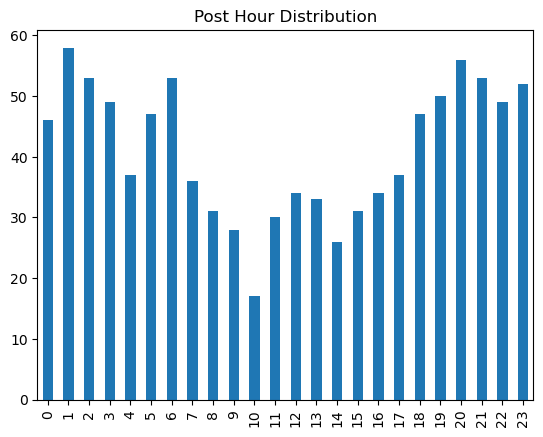

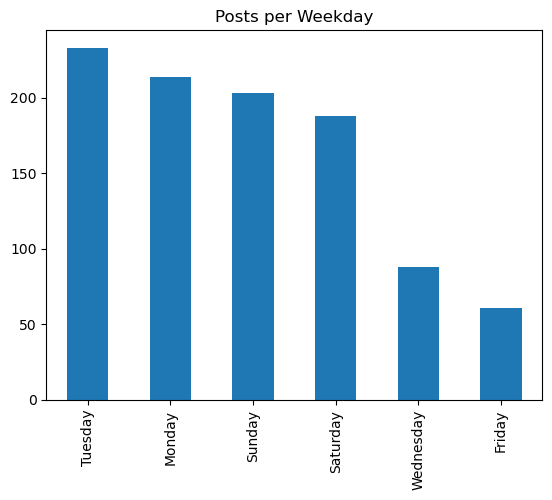

In [10]:
# Posting over time
data['hour'] = data['created_utc'].dt.hour
data['weekday'] = data['created_utc'].dt.day_name()

data['hour'].value_counts().sort_index().plot(kind='bar', title='Post Hour Distribution')
plt.show()
data['weekday'].value_counts().plot(kind='bar', title='Posts per Weekday')
plt.show()

Correlation of score and number of comments: 
                 score  num_comments
score         1.000000      0.716391
num_comments  0.716391      1.000000


<AxesSubplot:xlabel='score', ylabel='num_comments'>

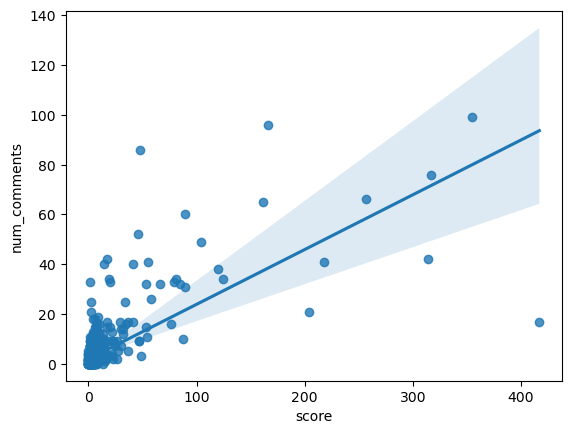

In [11]:
# Posts with high score and comments
data[['title', 'score', 'num_comments']].sort_values(by='score', ascending=False).head(5)

# Correlation between score and comment count
print(f"Correlation of score and number of comments: \n{data[['score', 'num_comments']].corr()}")

# Regplot
sns.regplot(x='score', y='num_comments', data=data)

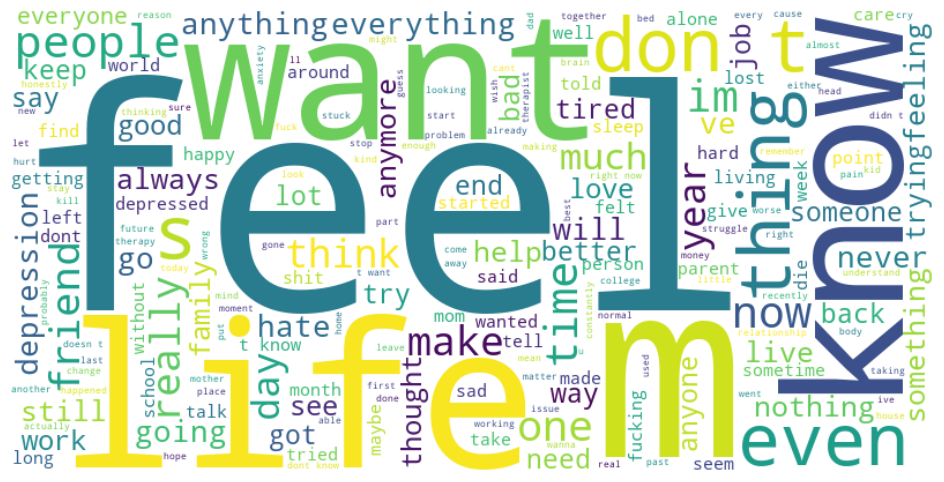

In [12]:
# Creating a word cloud
text = ' '.join(data['selftext'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()